In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

In [12]:
import numpy as np
import pandas as pd
import pylab as pl

In [3]:
valid_frac    = 0.2                 # fraction of training data to use for validation
epochs        = 100                 # number of training epochs
batch_size    = 128                 # number of samples per batch
input_size    = 8                   # The number of features
hidden_size   = 400                 # The number of nodes at the hidden layer
num_classes   = 2                   # The number of output classes. In this case, from 0 to 9
learning_rate = torch.tensor(1e-4)  # The speed of convergence
momentum      = torch.tensor(9e-1)  # momentum for optimizer
path          = "./"

In [4]:
class Classifier_MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.h1  = nn.Linear(in_dim, hidden_dim)
        self.h2  = nn.Linear(hidden_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, out_dim)
        self.out_dim = out_dim

        # weight initialisation:
        # following: https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
        for m in self.modules():
            if isinstance(m, nn.Linear):
                y = m.in_features
                nn.init.normal_(m.weight, 0, 1/np.sqrt(y))
                nn.init.constant_(m.bias, 0)


    def forward(self, x):
        
        x = F.relu(self.h1(x))
        x = F.relu(self.h2(x))
        x = self.out(x)
        
        return x, F.log_softmax(x,dim=1)

In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
print("Device: ",device)

Device:  cpu


In [6]:
infile = path+'pulsar.csv.gz'
htru1_df = pd.read_csv(infile, compression='gzip')
    
htru_x = htru1_df.drop('class', axis=1).values
htru_y = htru1_df['class'].values

In [7]:
htru_x  = torch.tensor(htru_x, dtype=torch.float)
htru_y  = torch.tensor(htru_y, dtype=torch.long)

x, y = Variable(htru_x), Variable(htru_y)
full_dataset = Data.TensorDataset(x, y)

valid_size = int(valid_frac * len(full_dataset))
train_size = len(full_dataset) - valid_size
train_dataset, valid_dataset = torch.utils.data.random_split(full_dataset, [train_size, valid_size])

train_loader = Data.DataLoader(dataset=train_dataset,
                               batch_size=batch_size,
                               shuffle=True)

valid_loader = Data.DataLoader(dataset=valid_dataset,
                               batch_size=batch_size,
                               shuffle=True)

In [8]:
model = Classifier_MLP(in_dim=input_size, hidden_dim=hidden_size, out_dim=num_classes)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

In [10]:
epoch_trainaccs, epoch_testaccs = [], []
epoch_trainloss, epoch_testloss = [], []

for epoch in range(epochs):  # loop over the dataset multiple times

    train_loss, train_accs=[],[]; acc = 0
    for batch, (x_train, y_train) in enumerate(train_loader):
        
        x_train, y_train = x_train.to(device), y_train.to(device)
        
        model.zero_grad()
        pred, _ = model(x_train)
        
        acc = (pred.argmax(dim=-1) == y_train).to(torch.float32).mean()
        train_accs.append(acc.mean().item())
        
        loss = F.cross_entropy(pred, y_train)
        train_loss.append(loss.item())
        
        loss.backward()
        optimizer.step()

    print('Epoch: {}, Train Loss: {:4f}'.format(epoch, np.mean(train_loss), np.mean(train_accs)))

    with torch.no_grad():
        test_loss, test_accs = [], []; acc = 0
        for i, (x_test, y_test) in enumerate(valid_loader):
            
            x_test, y_test = x_test.to(device), y_test.to(device)
            
            test_pred, _ = model(x_test)
            
            loss = F.cross_entropy(test_pred, y_test)
            
            acc = (test_pred.argmax(dim=-1) == y_test).to(torch.float32).mean()
            test_loss.append(loss.item())
            test_accs.append(acc.mean().item())

    print('Validation Loss: {:4f}, Validation Accuracy: {:4f}'.format(np.mean(test_loss), np.mean(test_accs)))

    epoch_trainaccs.append(np.mean(train_accs))
    epoch_testaccs.append(np.mean(test_accs))

    epoch_trainloss.append(np.mean(train_loss))
    epoch_testloss.append(np.mean(test_loss))

print('Finished Training')
print("Final test error: ",100.*(1 - epoch_testaccs[-1]))

Epoch: 0, Train Loss: 0.082422
Validation Loss: 0.110824, Validation Accuracy: 0.974029
Epoch: 1, Train Loss: 0.087292
Validation Loss: 0.091649, Validation Accuracy: 0.977935
Epoch: 2, Train Loss: 0.084238
Validation Loss: 0.102139, Validation Accuracy: 0.976562
Epoch: 3, Train Loss: 0.084691
Validation Loss: 0.105949, Validation Accuracy: 0.975703
Epoch: 4, Train Loss: 0.084883
Validation Loss: 0.097341, Validation Accuracy: 0.976807
Epoch: 5, Train Loss: 0.082983
Validation Loss: 0.101353, Validation Accuracy: 0.977377
Epoch: 6, Train Loss: 0.083226
Validation Loss: 0.110951, Validation Accuracy: 0.975691
Epoch: 7, Train Loss: 0.083514
Validation Loss: 0.090905, Validation Accuracy: 0.977377
Epoch: 8, Train Loss: 0.083229
Validation Loss: 0.090125, Validation Accuracy: 0.977121
Epoch: 9, Train Loss: 0.083291
Validation Loss: 0.092751, Validation Accuracy: 0.977946
Epoch: 10, Train Loss: 0.081532
Validation Loss: 0.089285, Validation Accuracy: 0.977075
Epoch: 11, Train Loss: 0.086388

Epoch: 93, Train Loss: 0.079418
Validation Loss: 0.098645, Validation Accuracy: 0.977377
Epoch: 94, Train Loss: 0.080195
Validation Loss: 0.093058, Validation Accuracy: 0.977075
Epoch: 95, Train Loss: 0.079571
Validation Loss: 0.097469, Validation Accuracy: 0.975424
Epoch: 96, Train Loss: 0.081844
Validation Loss: 0.089344, Validation Accuracy: 0.979285
Epoch: 97, Train Loss: 0.080080
Validation Loss: 0.092448, Validation Accuracy: 0.977645
Epoch: 98, Train Loss: 0.080475
Validation Loss: 0.102376, Validation Accuracy: 0.977064
Epoch: 99, Train Loss: 0.080074
Validation Loss: 0.096147, Validation Accuracy: 0.978214
Finished Training
Final test error:  2.1786076681954536


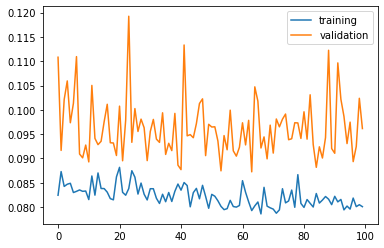

In [16]:
pl.subplot(111)
pl.plot(epoch_trainloss, label="training")
pl.plot(epoch_testloss, label="validation")
pl.legend()
pl.show()